In [67]:
# !pip install yellowbrick

In [68]:
import pandas as pd
import numpy as np
from itertools import cycle

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, estimate_bandwidth, MeanShift, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from yellowbrick.cluster import KElbowVisualizer

%matplotlib inline

## Importing and cleaning data

In [69]:
# Import data and clean up dataframe
data = pd.read_csv('irisdata.txt', sep = ',', header = None)
data.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']
data.at[34, 'Petal Width'] = 0.2
data.at[37, 'Sepal Width'] = 3.6
data.at[37, 'Petal Length'] = 1.4

## Elbow Plot

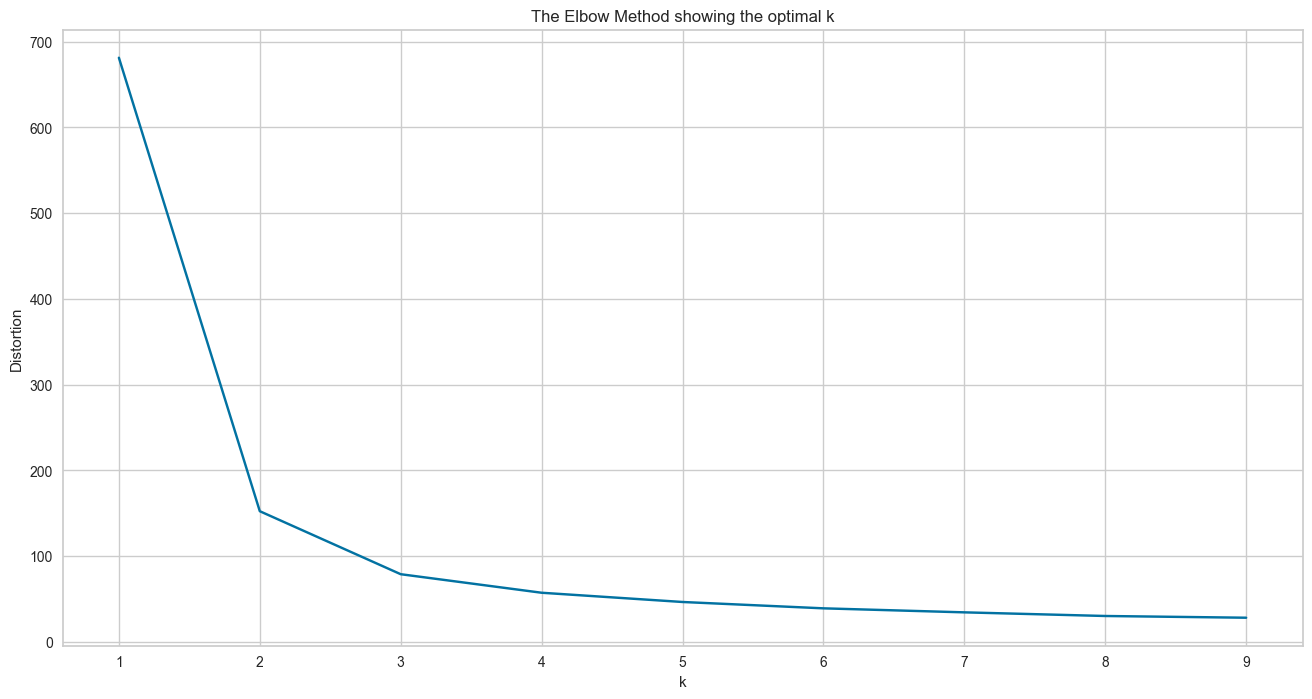

In [70]:
# Create an elbow plot using k-means 
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data.loc[:, data.columns != 'Species'])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

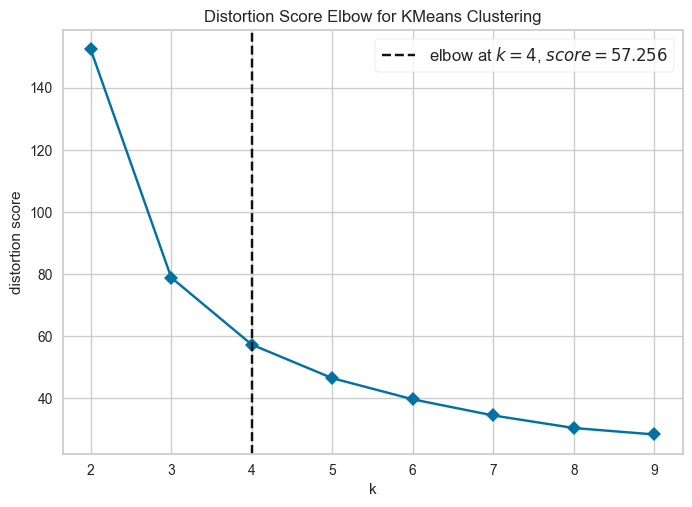

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [71]:
# create an elbow plot using KElbowVisualizer from the yellowbrick package
# default metric: distortion
visualizer1 = KElbowVisualizer(KMeans(),k=(2,10),timings=False)

visualizer1.fit(data.loc[:, data.columns != 'Species'])
visualizer1.show()



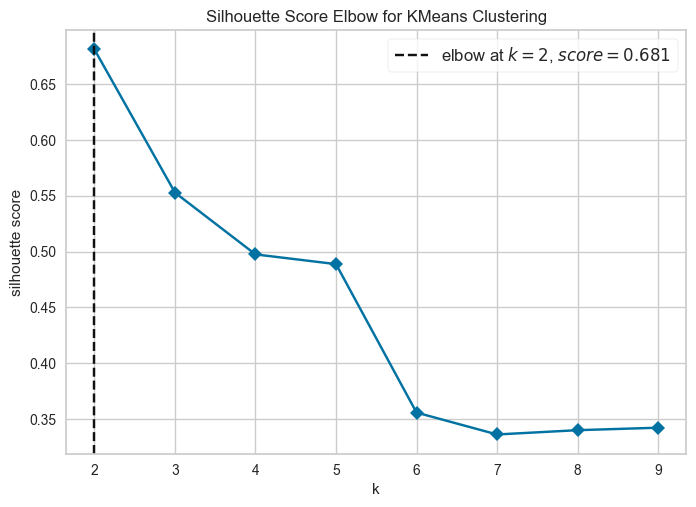

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [72]:
# metric 2: silhouette
visualizer2 = KElbowVisualizer(KMeans(),k=(2,10),metric='silhouette',timings=False)

visualizer2.fit(data.loc[:, data.columns != 'Species'])
visualizer2.show()

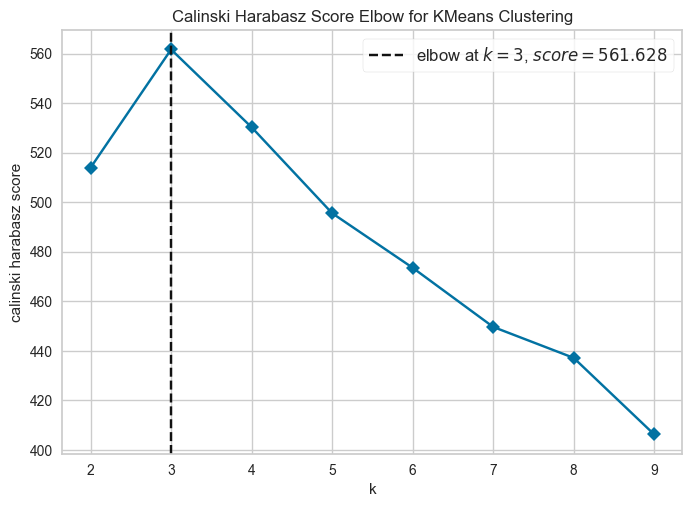

<AxesSubplot: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [73]:
# metric 3: calinski_harabasz
visualizer3 = KElbowVisualizer(KMeans(),k=(2,10),metric='calinski_harabasz',timings=False)

visualizer3.fit(data.loc[:, data.columns != 'Species'])
visualizer3.show()

## PCA

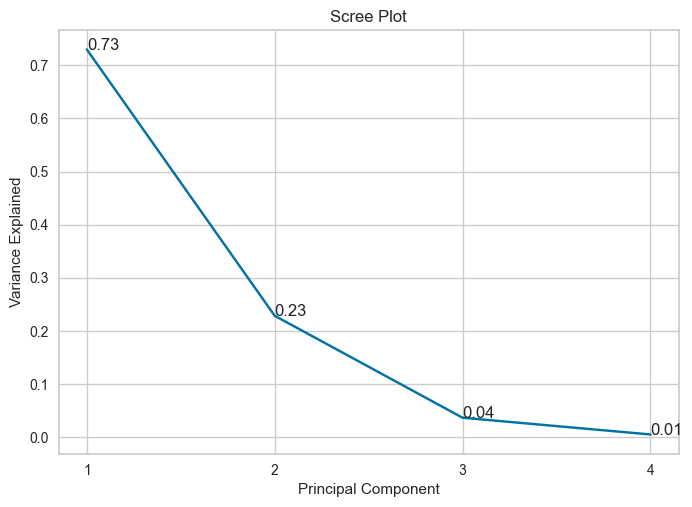

In [74]:
#SCREE plot to determine how many components to use
features = data[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']]
scaled_features = StandardScaler().fit_transform(features)
scree_pca = PCA(n_components=4)
scree_fit = scree_pca.fit(scaled_features)

PC_values = np.arange(scree_pca.n_components_) + 1

plt.plot(PC_values,scree_pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.xticks(ticks=[1,2,3,4])
plt.ylabel('Variance Explained')
for a,b in zip(PC_values,scree_pca.explained_variance_ratio_):
    plt.text(a,b, str(round(b,2)))
plt.show()

As shown with our scree plot, PC4 only explains ~1% of the variance, so we can explain 99% of our variance using only 3 features.

In [75]:
# Reduce dataframe using PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(principalComponents,columns=['PC1','PC2','PC3'])
pca_df.head()

,PC1,PC2,PC3
0,-2.264703,0.480027,-0.127706
1,-2.080961,-0.674134,-0.234609
2,-2.364229,-0.341908,0.044201
3,-2.299384,-0.597395,0.091290
4,-2.389842,0.646835,0.015738


In [76]:
# 2d scatter plot of PCA
fig = px.scatter(pca_df, x='PC1', y='PC2', color=data['Species'])
fig.show()

In [77]:
# 3d plot of PCA
px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color = data['Species'], color_discrete_sequence = px.colors.qualitative.Prism,
             title = 'PCA 3d Plot')

## K-Means Clustering

In [78]:
k_x = data.loc[:, data.columns != 'Species'].values
k_y = data.loc[:, data.columns == 'Species'].values

In [79]:
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_kmeans = kmeans.fit_predict(k_x)
k_centers = kmeans.cluster_centers_
k_n_clusters = len(k_centers)
k_labels = kmeans.predict(k_x)

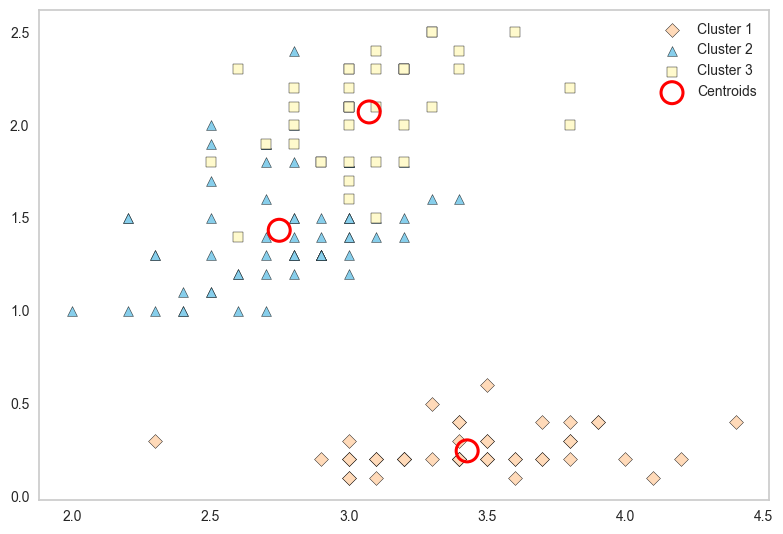

In [80]:
# 2d scatter plot of K-Means Clustering
plt.scatter(k_x[y_kmeans == 0, 1], k_x[y_kmeans == 0, 3], s=50,
           c='peachpuff', marker='D', edgecolor='black', label='Cluster 1')
plt.scatter(k_x[y_kmeans == 1, 1], k_x[y_kmeans == 1, 3], s=50,
           c='skyblue', marker='^', edgecolor='black', label='Cluster 2')
plt.scatter(k_x[y_kmeans == 2, 1], k_x[y_kmeans == 2, 3], s=50,
           c='lemonchiffon', marker='s', edgecolor='black', label='Cluster 3')
plt.scatter(k_centers[:,1], k_centers[:, 3], s=250,
           marker='o', edgecolor='red', linewidth=2.2, facecolor='none', label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

In [81]:
# vectorize y species values to calculate statistics
d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
k_y = k_y.flatten()
k_y = np.vectorize(d.get)(k_y)

In [82]:
print('Estimated number of clusters: %d' % k_n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(k_y, k_labels))
print("Completeness: %0.3f" % metrics.completeness_score(k_y, k_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(k_y, k_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(k_y, k_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(k_y, k_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(k_x, k_labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.751
Completeness: 0.765
V-measure: 0.758
Adjusted Rand Index: 0.730
Adjusted Mutual Information: 0.755
Silhouette Coefficient: 0.736


## Affinity Propogation

In [83]:
affinity_x = data.loc[:, data.columns != 'Species'].values
affinity_y = data.loc[:, data.columns == 'Species'].values
ap = AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True, damping=0.5, max_iter=200, 
                         preference=-20, verbose=False, random_state=0)
ap.fit(affinity_x)
y_affinity = ap.fit_predict(affinity_x)
a_centers = ap.cluster_centers_
a_indices = ap.cluster_centers_indices_
a_n_clusters = len(a_centers)
a_labels = ap.predict(affinity_x)

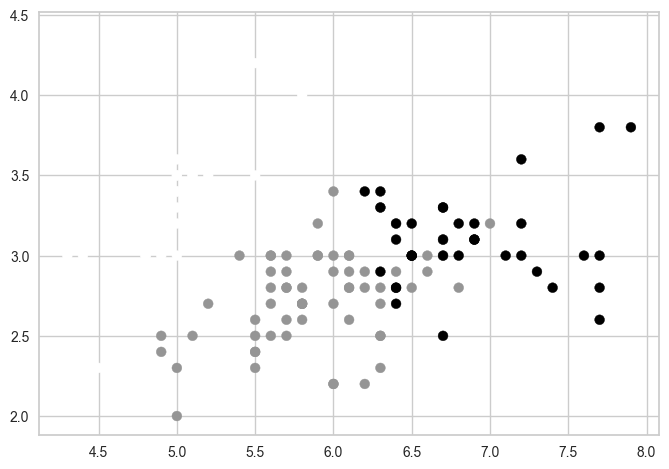

In [84]:
plt.scatter(affinity_x[:, 0], affinity_x[:, 1], c=a_labels, s=50)

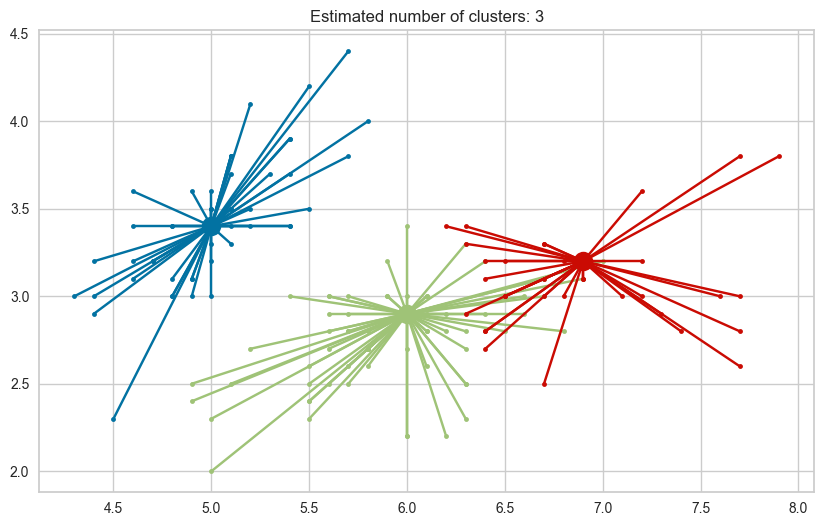

In [85]:
plt.close("all")
plt.figure(1, figsize=[10,6])
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(a_n_clusters), colors):
    class_members = a_labels == k
    cluster_center = affinity_x[a_indices[k]]
    plt.plot(affinity_x[class_members, 0], affinity_x[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for x in affinity_x[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % a_n_clusters)
plt.show()

In [86]:
# vectorize y species values to calculate statistics
d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
affinity_y = affinity_y.flatten()
affinity_y = np.vectorize(d.get)(affinity_y.flatten())

In [87]:
# Statistics for Affinity Propagation

print('Estimated number of clusters: %d' % a_n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(affinity_y, a_labels))
print("Completeness: %0.3f" % metrics.completeness_score(affinity_y, a_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(affinity_y, a_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(affinity_y, a_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(affinity_y, a_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(affinity_x, a_labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.787
Completeness: 0.809
V-measure: 0.798
Adjusted Rand Index: 0.746
Adjusted Mutual Information: 0.795
Silhouette Coefficient: 0.735


## Agglomerative Clustering

In [88]:
ag = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward')

ag_predict = ag.fit_predict(features)
ag_labels = ag.labels_
ag_clusters = ag.n_clusters_
ag_leaves = ag.n_leaves_

In [89]:
# scatter plot
fig = px.scatter(
    data,
    x='Petal Length',
    y='Petal Width',
    color='Species',
    symbol= ag_predict
)
fig.show()

Based on the scatter plot (and the corresponding legend), we can see 1 cluster encompassed a single species (setosa). The other 2 clusters were some mix of versicolor and virginica.

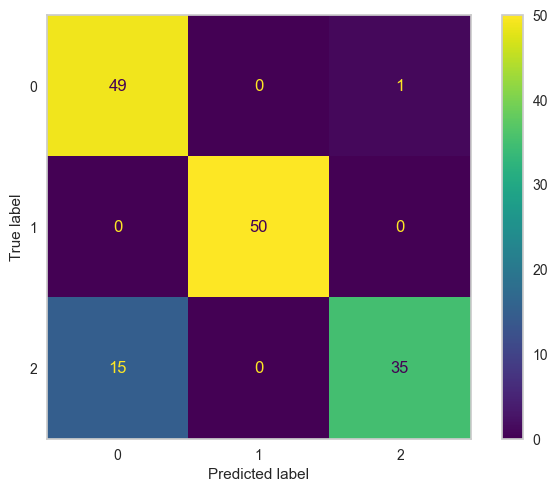

In [90]:
# confusion matrix
d = {'Iris-versicolor': 0, 'Iris-setosa': 1, 'Iris-virginica': 2}
target = data['Species'].replace(d)

metrics.ConfusionMatrixDisplay.from_predictions(target,ag_predict)
plt.grid(visible=None)
plt.show()

This confusion matrix confirms that all setosa flowers were clustered together, and there weren't any other species of flower mixed into that cluster. However, about 15 virginica flowers were clustered with 49 of the 50 versicolor flowers, and the remaining versicolor flower was clustered with the remaining 35 virginica flowers.

In [91]:
# Statistics

print('Estimated number of clusters: %d' % ag_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(data["Species"],ag_labels))
print("Completeness: %0.3f" % metrics.completeness_score(data["Species"],ag_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(data["Species"],ag_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(data["Species"],ag_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(data["Species"],ag_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(features, ag_labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.761
Completeness: 0.780
V-measure: 0.770
Adjusted Rand Index: 0.731
Adjusted Mutual Information: 0.767
Silhouette Coefficient: 0.735


### Agglomerative Clustering for PCA dataframe

In [92]:
ag_p = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward')

ag_predict_pca = ag_p.fit_predict(pca_df)
ag_labels_pca = ag_p.labels_
ag_clusters_pca = ag_p.n_clusters_
ag_leaves_pca = ag_p.n_leaves_

In [93]:
# scatter plot (displaying all 3 principal components)
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color=data['Species'],
    symbol= ag_predict_pca
)
fig.show()

By briefly observing this scatter plot, we can see that there was one cluster that included at least 1 of each species, but the other 2 clusters included only 1 species.

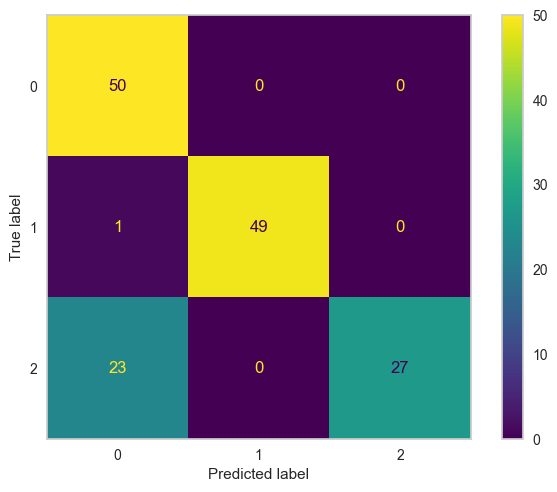

In [94]:
# confusion matrix
d = {'Iris-versicolor': 0, 'Iris-setosa': 1, 'Iris-virginica': 2}
target = data['Species'].replace(d)

metrics.ConfusionMatrixDisplay.from_predictions(target,ag_predict_pca)
plt.grid(visible=None)
plt.show()

This time around all versicolor flowers were included in the same cluster, but that cluster also included a setosa flower and 23 virginica flowers. The 2nd cluster included all the remaining setosa flowers, with no other flowers from another iris species. And the 3rd cluster had the last 27 flowers, all virginica.

In [95]:
print('Estimated number of clusters: %d' % ag_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(data["Species"],ag_labels_pca))
print("Completeness: %0.3f" % metrics.completeness_score(data["Species"],ag_labels_pca))
print("V-measure: %0.3f" % metrics.v_measure_score(data["Species"],ag_labels_pca))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(data["Species"],ag_labels_pca))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(data["Species"],ag_labels_pca))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(pca_df, ag_labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.692
Completeness: 0.743
V-measure: 0.717
Adjusted Rand Index: 0.630
Adjusted Mutual Information: 0.713
Silhouette Coefficient: 0.633


### Mean Shift

In [96]:
# Apply Mean Shift to original dataframe
bandwidth = estimate_bandwidth(scaled_features, quantile = 0.2, n_samples = len(scaled_features))
mean_shift = MeanShift(bandwidth = bandwidth, bin_seeding = True)
mean_shift.fit(scaled_features)
ms_data_labels = mean_shift.labels_
ms_data_cluster_centers = mean_shift.cluster_centers_

unique_ms_data_labels = np.unique(ms_data_labels)
num_ms_data_clusters_ = len(unique_ms_data_labels)
print("Number of clusters : %d" % num_ms_data_clusters_)
print(ms_data_cluster_centers)

Number of clusters : 3
[[ 0.37466201 -0.36607789  0.5777958   0.5653342 ]
 [-1.08982126  0.70458926 -1.302797   -1.26407564]
 [ 2.12851559  1.55613014  1.50164482  1.36107679]]


Applying Mean Shift to the original dataframe results in the identification of 3 clusters and produces the coordinates for each cluster.

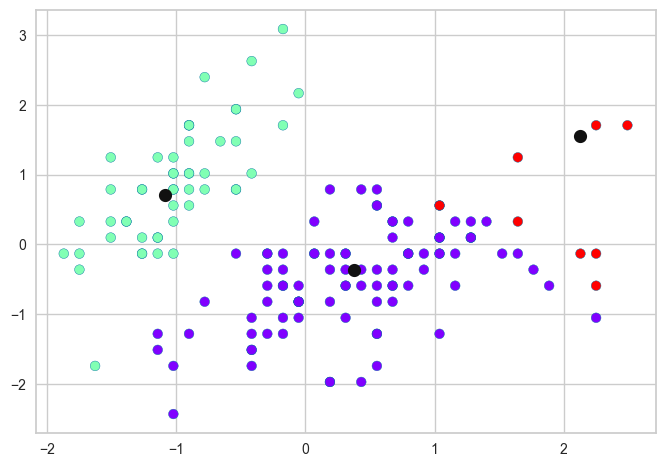

In [97]:
# Create plot of clusters derived from original data
plt.scatter(scaled_features[:,0], scaled_features[:,1], c = ms_data_labels, cmap = 'rainbow', edgecolors = 'b')
plt.scatter(ms_data_cluster_centers[:,0], ms_data_cluster_centers[:,1],
     color = 'k', s = 20, linewidths = 5)
plt.show()

The scatter plot depicts the relationship between the original data points and the clusters identified by the Mean Shift.

In [98]:
# Apply Mean Shift to PCA dataframe
bandwidth = estimate_bandwidth(scaled_features, quantile = 0.2, n_samples = len(pca_df))
mean_shift = MeanShift(bandwidth = bandwidth, bin_seeding = True)
mean_shift.fit(pca_df)
ms_pcs_labels = mean_shift.labels_
ms_pcs_cluster_centers = mean_shift.cluster_centers_

unique_ms_pcs_labels = np.unique(ms_pcs_labels)
num_ms_pcs_clusters_ = len(unique_ms_pcs_labels)
print("Number of clusters : %d" % num_ms_pcs_clusters_)
print(ms_pcs_cluster_centers)

Number of clusters : 4
[[ 0.93736136 -0.16085551  0.08185329]
 [-2.22782985  0.12269913 -0.03054304]
 [ 2.33034469  2.36799837 -0.07460112]
 [-1.85812246 -2.33741516 -0.20423422]]


Applying Mean Shift to the PCA dataframe results in the identification of 4 clusters and produces the coordinates for each cluster.

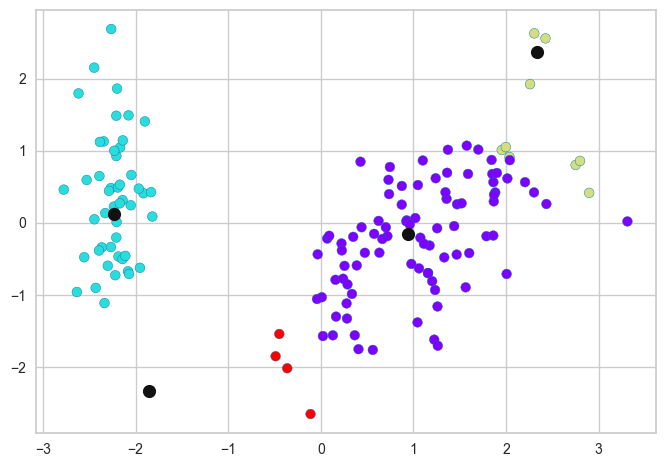

In [99]:
# Create plot of clusters derived from principal components
plt.scatter(pca_df['PC1'], pca_df['PC2'], c = ms_pcs_labels, cmap = 'rainbow', edgecolors = 'b')
plt.scatter(ms_pcs_cluster_centers[:,0], ms_pcs_cluster_centers[:,1],
     color = 'k', s = 20, linewidths = 5)
plt.show()

The scatter plot depicts the relationship between the principal components and the clusters identified by the Mean Shift.

### Conclusions: Mean shift

The application of Mean Shift to the principal components appears to provide better results than seen with the application of the technique to the original dataset, as the distribution of the data points has a much narrower spreads. That is, the clusters become more apparent when derived from the principal components.

### Spectral Clustering

In [100]:
# Apply Spectral Clustering to original dataframe
spec_clust = SpectralClustering(n_clusters = 3)
spec_clust.fit(scaled_features)
sc_data_labels = spec_clust.labels_
unique_sc_data_labels = np.unique(sc_data_labels)
num_sc_data_clusters_ = len(unique_sc_data_labels)

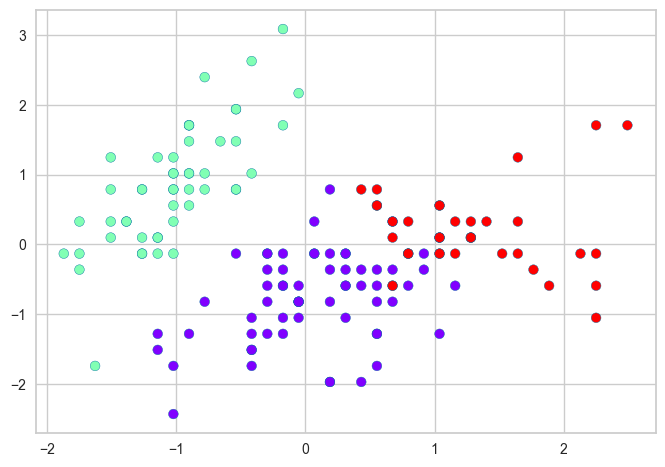

In [101]:
# Create Spectral Clustering plot
plt.scatter(scaled_features[:,0], scaled_features[:,1], c = sc_data_labels, cmap = 'rainbow', edgecolors = 'b')
plt.show()

In [102]:
# Apply Spectral Clustering to PCA dataframe
spec_clust = SpectralClustering(n_clusters = 3)
spec_clust.fit(pca_df)
sc_pcs_labels = spec_clust.labels_
unique_sc_pcs_labels = np.unique(sc_pcs_labels)
num_sc_pcs_clusters_ = len(unique_sc_pcs_labels)

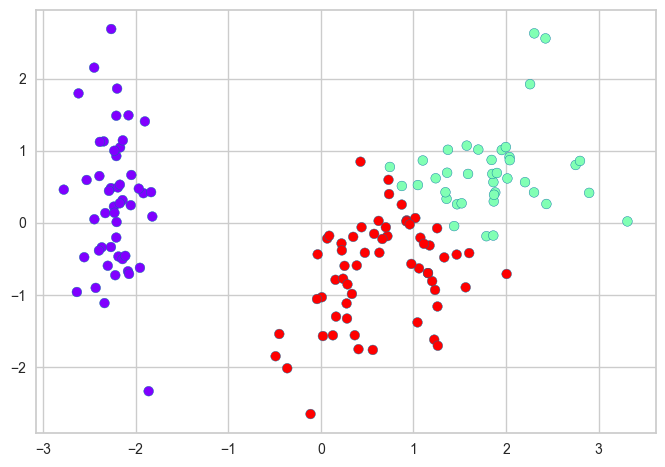

In [103]:
# Create Spectral Clustering plot
plt.scatter(pca_df['PC1'], pca_df['PC2'], c = sc_pcs_labels, cmap = 'rainbow', edgecolors = 'b')
plt.show()

### Conclusions: Spectral Clustering
Similarly, utilizing the principal components in the application of Spectral Clustering proves to generate improved results when compared to the results associated with the original dataset. The clusters are more well-defined due to the more compact distribution of data.